In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 

from datetime import datetime

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
dir_path = os.getcwd()
dir_path

'/Users/nicolasmaquaire/Dropbox/KLoop/Dev/190209_MLEnvs'

In [3]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
savedir = "models/Tensor_CIFAR_Sparse_model/" + "run-{}/".format(now)

In [4]:
print(savedir)

models/Tensor_CIFAR_Sparse_model/run-20190426161558/


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
cifar10_1 = unpickle('datasets/cifar-10/data_batch_1')

In [7]:
cifar10_dataset_folder_path = 'datasets/cifar-10/'

In [8]:
list(cifar10_1.keys())

[b'batch_label', b'labels', b'data', b'filenames']

In [9]:
len(cifar10_1[b'data']),len(cifar10_1[b'labels'])

(10000, 10000)

In [10]:
cifar10_1[b'batch_label']

b'training batch 1 of 5'

In [11]:
cifar10_Label_names = unpickle('datasets/cifar-10/batches.meta')
cifar10_Label_names[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [12]:
label_names = []
for x in cifar10_Label_names[b'label_names']:
    label = x.decode()
    label_names.append(label)

In [13]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [14]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [15]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


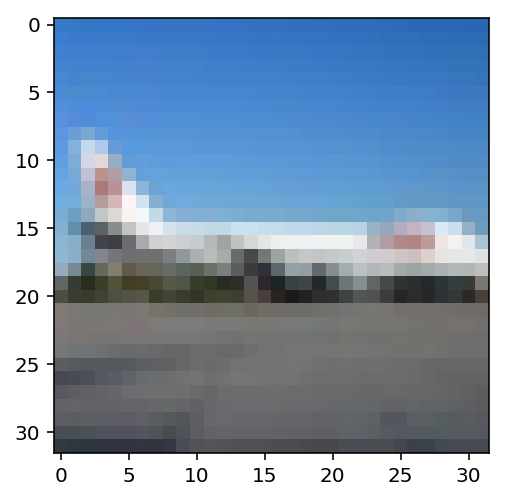

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [17]:
def normalize(x):

    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    
    x = x.astype('float32')
    
    return x

In [18]:
def one_hot_encode(x):

    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [19]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))

In [20]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    all_features = []
    all_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
        all_features.extend(features[:-index_of_validation])
        all_labels.extend(labels[:-index_of_validation])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'datasets/preprocess_validation.p')
                                 
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(all_features), np.array(all_labels),
                         'datasets/preprocess_all.p')
    

In [21]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [22]:
valid_features, valid_labels = pickle.load(open('datasets/preprocess_validation.p', mode='rb'))
print(valid_features.dtype)
print(valid_features.shape)

float32
(5000, 32, 32, 3)


In [23]:
train_features, train_labels = pickle.load(open('datasets/preprocess_all.p', mode='rb'))
print(train_features.dtype)
print(train_features.shape)

float32
(45000, 32, 32, 3)


In [24]:
def cnn_model_fn(features, labels, mode):
    
    with tf.name_scope('model_input') as scope:
        input_layer = tf.reshape(features, [-1, 32, 32, 3], name="input")
        
    with tf.name_scope('model_conv1') as scope:    
        conv1 = tf.layers.conv2d(inputs=input_layer, filters=64, kernel_size=[5, 5], 
                                 padding="same", activation=tf.nn.relu6, 
                                 trainable=mode == tf.estimator.ModeKeys.TRAIN)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=(2,2))
        
    with tf.name_scope('model_conv2') as scope:
        conv2 = tf.layers.conv2d(inputs=pool1, filters=128, kernel_size=[5, 5], 
                                 padding="same", activation=tf.nn.relu6, 
                                 trainable=mode == tf.estimator.ModeKeys.TRAIN)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=(2,2))
    
    with tf.name_scope('model_dense') as scope:
        pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 128]) 
    
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, 
                                activation=tf.nn.relu6, 
                                trainable=mode == tf.estimator.ModeKeys.TRAIN)
        
        dropout = tf.layers.dropout(inputs=dense, rate=0.25, training=mode == tf.estimator.ModeKeys.TRAIN)
        
    with tf.name_scope('model_output') as scope:    
        logits = tf.layers.dense(inputs=dropout, units=10, trainable=mode == tf.estimator.ModeKeys.TRAIN)
        # shape should be:[-1, 10]
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # PREDICT mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        export_outputs = {
            'predict_output': tf.estimator.export.PredictOutput(predictions)
        }
        
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, export_outputs=export_outputs)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
    
    
    # TRAIN mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        g = tf.get_default_graph()
        tf.contrib.quantize.create_training_graph(input_graph=g, quant_delay=6000) 
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # EVAL mode
    g = tf.get_default_graph()
    tf.contrib.quantize.create_eval_graph(input_graph=g)
    labels = tf.argmax(labels, axis=1)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

    

In [25]:
#see for options here: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/protobuf/config.proto
#sess_config = tf.ConfigProto(gpu_options=gpu_options)

run_cfg = tf.estimator.RunConfig( 
    model_dir=savedir,
    tf_random_seed=2,
    save_summary_steps=2,
    #session_config = sess_config,
    save_checkpoints_steps=100,
    keep_checkpoint_max=1) 

In [26]:
# Instantiate the Estimator
cifar10_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn, config=run_cfg) 

INFO:tensorflow:Using config: {'_model_dir': 'models/Tensor_CIFAR_Sparse_model/run-20190426161558/', '_tf_random_seed': 2, '_save_summary_steps': 2, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13fb985f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=100)

In [28]:
def fit_all_batches(xEpochs):
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=train_features,
        y=train_labels,
        batch_size=32,
        num_epochs=xEpochs,
        shuffle=False)
        
    # train one step and display the probabilties
    cifar10_classifier.train(
        input_fn=train_input_fn,
        steps=None, 
        hooks=[logging_hook]) 

In [29]:
fit_all_batches(10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.

INFO:tensorflow:loss = 1.9622906, step = 101 (14.895 sec)
INFO:tensorflow:Saving checkpoints for 200 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.42725
INFO:tensorflow:probabilities = [[0.1354451  0.0259886  0.05410798 0.19438705 0.01077578 0.19824477
  0.00943877 0.00663096 0.32068217 0.04429882]
 [0.16986653 0.01066614 0.01454537 0.00722235 0.03424514 0.00435874
  0.0018672  0.19046299 0.04817491 0.5185906 ]
 [0.04069289 0.0519653  0.05936771 0.1383787  0.06348649 0.28373265
  0.02017146 0.20078391 0.03554402 0.10587689]
 [0.2655573  0.05839415 0.06446882 0.04674549 0.05355882 0.02342071
  0.0149843  0.04125835 0.21827632 0.21333575]
 [0.03987306 0.07898176 0.06718664 0.21061607 0.05613479 0.30770296
  0.08969864 0.04686463 0.05512496 0.04781643]
 [0.1843588  0.05465786 0.13342951 0.13045214 0.0738406  0.10433386
  0.04051038 0.05898057 0.14137454 0.07806178]
 [0.02062869 0.01781282 0.15847532 0.13532148 0.23411533 0.10010634

INFO:tensorflow:loss = 1.6639032, step = 401 (13.505 sec)
INFO:tensorflow:Saving checkpoints for 500 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.76333
INFO:tensorflow:probabilities = [[0.00046648 0.00136028 0.01531547 0.03331231 0.02005787 0.01022405
  0.91466945 0.00104054 0.0000989  0.00345465]
 [0.00185041 0.00173754 0.01308125 0.03110303 0.04653061 0.03635992
  0.16015995 0.6922303  0.00016043 0.01678654]
 [0.04857376 0.07576254 0.00368812 0.00047709 0.00768616 0.00009722
  0.00143983 0.00045932 0.6457623  0.21605368]
 [0.00443926 0.00483878 0.07470801 0.08745921 0.14436452 0.09266178
  0.55159754 0.03235188 0.00099304 0.00658592]
 [0.19952646 0.06784107 0.38445574 0.03611429 0.0727033  0.01359998
  0.0312871  0.00442015 0.10480292 0.08524902]
 [0.0004683  0.000287   0.00231297 0.00198655 0.01766295 0.0070547
  0.00206321 0.9676312  0.00001246 0.0005206 ]
 [0.00427487 0.00070914 0.2454168  0.22657211 0.13886671 0.2489993
 

INFO:tensorflow:loss = 1.3497032, step = 701 (14.171 sec)
INFO:tensorflow:Saving checkpoints for 800 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.86273
INFO:tensorflow:probabilities = [[0.01706379 0.00102732 0.3200465  0.01227523 0.34632996 0.04355444
  0.01527599 0.24256454 0.0007285  0.0011337 ]
 [0.0177216  0.05072419 0.03109115 0.0753461  0.27263767 0.05011356
  0.3832411  0.05853553 0.00993043 0.05065869]
 [0.0003949  0.00037362 0.01092565 0.02815502 0.02321877 0.00419288
  0.9318357  0.00040617 0.00016317 0.00033419]
 [0.0558473  0.1266282  0.01736367 0.0044083  0.01415224 0.00481809
  0.00099257 0.03757344 0.00785612 0.73036003]
 [0.01719144 0.00078055 0.26043174 0.01878353 0.47636312 0.0260263
  0.0692342  0.1298966  0.00058808 0.00070441]
 [0.04144263 0.00435909 0.38137963 0.05446771 0.2525759  0.0351261
  0.18972549 0.00990615 0.02570484 0.0053125 ]
 [0.07531674 0.01454575 0.2743885  0.13912855 0.12703548 0.14378817
 

INFO:tensorflow:loss = 1.3737054, step = 1001 (13.788 sec)
INFO:tensorflow:Saving checkpoints for 1100 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.91672
INFO:tensorflow:probabilities = [[0.00881216 0.00545044 0.03660628 0.4824723  0.17239326 0.06836531
  0.11367373 0.10465453 0.00051861 0.00705342]
 [0.00071482 0.00001454 0.0117274  0.00663347 0.01479982 0.0296963
  0.00131132 0.9348727  0.00008483 0.00014484]
 [0.03737517 0.00360204 0.03726245 0.26210463 0.04184999 0.46232715
  0.09623618 0.05359512 0.00111785 0.00452936]
 [0.00588629 0.0001506  0.00908745 0.05135281 0.05577085 0.1422146
  0.00488083 0.7301105  0.00008036 0.00046567]
 [0.00011152 0.97101295 0.00000048 0.00000277 0.00000462 0.0000005
  0.00002323 0.00000022 0.01501453 0.01382928]
 [0.7571186  0.05930406 0.04460787 0.00511479 0.01124795 0.00078887
  0.00025076 0.00108212 0.11561937 0.0048657 ]
 [0.05752635 0.01540331 0.19472857 0.1670059  0.21585378 0.06972785


INFO:tensorflow:loss = 1.4342954, step = 1301 (14.482 sec)
INFO:tensorflow:Saving checkpoints for 1400 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.86312
INFO:tensorflow:probabilities = [[0.39367086 0.06719431 0.01226595 0.001292   0.03282744 0.00024517
  0.0000879  0.00114266 0.44313332 0.0481404 ]
 [0.12143381 0.15114476 0.10565887 0.05885625 0.24616592 0.05982782
  0.10290956 0.05580046 0.04586349 0.05233904]
 [0.00450222 0.01532481 0.01348949 0.21062556 0.03882222 0.13374002
  0.5155888  0.03374116 0.00554965 0.0286161 ]
 [0.00007206 0.00014125 0.003263   0.00082605 0.00554092 0.00616418
  0.00005163 0.9839271  0.00000435 0.00000934]
 [0.00156011 0.00216947 0.05321823 0.00538829 0.17024776 0.0075497
  0.75183344 0.00683136 0.00029018 0.00091153]
 [0.09113005 0.01365601 0.01506343 0.00851805 0.00954377 0.00160091
  0.00186381 0.00096141 0.84251523 0.01514741]
 [0.00523124 0.5618063  0.00262744 0.03937799 0.00114105 0.0291682

INFO:tensorflow:loss = 1.3145726, step = 1601 (14.294 sec)
INFO:tensorflow:Saving checkpoints for 1700 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.96354
INFO:tensorflow:probabilities = [[0.00486424 0.00721736 0.07500653 0.03361803 0.33050376 0.02003851
  0.5013865  0.02190442 0.00160702 0.00385364]
 [0.6868568  0.02629368 0.03892879 0.00228386 0.01889145 0.00059869
  0.00081432 0.00101064 0.21542645 0.00889538]
 [0.01710752 0.00079368 0.00052046 0.00014282 0.00004428 0.00002409
  0.00003008 0.00001978 0.9656921  0.01562515]
 [0.00000063 0.9952939  0.         0.00000004 0.         0.
  0.00000007 0.         0.00003053 0.00467485]
 [0.06641277 0.00320121 0.1273073  0.01486947 0.7023617  0.00993604
  0.0428737  0.0281377  0.00398463 0.0009155 ]
 [0.00178923 0.49500307 0.00070305 0.00147262 0.00150163 0.0009696
  0.00074747 0.00545722 0.00547775 0.4868784 ]
 [0.12928858 0.02007238 0.07855292 0.14765306 0.02073915 0.09210092
  0.07

INFO:tensorflow:loss = 1.0873134, step = 1901 (13.540 sec)
INFO:tensorflow:Saving checkpoints for 2000 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.32789
INFO:tensorflow:probabilities = [[0.85180664 0.04797329 0.00606378 0.00007283 0.00522079 0.00014209
  0.00032834 0.00009449 0.08148497 0.00681282]
 [0.00741213 0.00000606 0.0069958  0.00097311 0.9684013  0.00038583
  0.00048746 0.01533675 0.00000115 0.00000042]
 [0.00254483 0.00000209 0.20193239 0.00600087 0.6661926  0.00493071
  0.11334997 0.00493872 0.00009567 0.00001214]
 [0.00016052 0.9919492  0.00008714 0.00039305 0.00001003 0.00009381
  0.00036097 0.00003447 0.00039631 0.00651455]
 [0.00083052 0.00179504 0.01500677 0.00326012 0.01805198 0.00126268
  0.9591648  0.00035899 0.00003976 0.0002294 ]
 [0.13463482 0.09583538 0.00143426 0.00325359 0.00054899 0.00119728
  0.00012957 0.00266683 0.14172949 0.6185698 ]
 [0.00257761 0.00090991 0.59011227 0.01620554 0.09096169 0.168821

INFO:tensorflow:loss = 1.0624444, step = 2201 (13.674 sec)
INFO:tensorflow:Saving checkpoints for 2300 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.46923
INFO:tensorflow:probabilities = [[0.10575105 0.00058293 0.14340742 0.2507358  0.05542121 0.12923367
  0.28705227 0.00864361 0.01724049 0.00193153]
 [0.01456364 0.0009103  0.14904958 0.22425665 0.27592912 0.17414221
  0.143505   0.01492376 0.00177556 0.00094412]
 [0.01905924 0.0000228  0.5021078  0.12436597 0.05616992 0.28599632
  0.01055769 0.00135974 0.00032732 0.00003324]
 [0.00448804 0.00016526 0.23840657 0.3198027  0.06067821 0.30927822
  0.02817804 0.03102775 0.00737354 0.0006016 ]
 [0.00024442 0.9805534  0.00000636 0.00013235 0.00004925 0.00001076
  0.0000023  0.00019307 0.00005741 0.01875075]
 [0.0187211  0.00216256 0.00130516 0.00099364 0.00006896 0.00010588
  0.00003606 0.00005146 0.74245554 0.23409961]
 [0.00095551 0.00012956 0.01445067 0.17958587 0.02692795 0.099856

INFO:tensorflow:loss = 1.4650692, step = 2501 (14.486 sec)
INFO:tensorflow:Saving checkpoints for 2600 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.89915
INFO:tensorflow:probabilities = [[0.01775212 0.00930374 0.20380159 0.203933   0.15060611 0.18563071
  0.04670549 0.17114629 0.00444286 0.00667803]
 [0.4286746  0.0153561  0.03826395 0.03205712 0.02326508 0.00392252
  0.00502877 0.00307694 0.32361886 0.12673597]
 [0.03645454 0.04145366 0.00037672 0.00165683 0.00083794 0.00005683
  0.0000373  0.00017527 0.90990955 0.00904135]
 [0.00517702 0.09506477 0.00005572 0.00017213 0.00011334 0.00000176
  0.0000382  0.00000012 0.8856825  0.0136945 ]
 [0.9385839  0.00208955 0.00171357 0.00060908 0.00076705 0.00003972
  0.00001926 0.00037603 0.03631549 0.01948631]
 [0.5672019  0.15163407 0.00357987 0.00112543 0.00216639 0.00003723
  0.00019451 0.00016051 0.23208527 0.04181481]
 [0.01063304 0.01489774 0.01098043 0.57204163 0.00402197 0.214102

INFO:tensorflow:loss = 1.0885881, step = 2801 (14.642 sec)
INFO:tensorflow:Saving checkpoints for 2900 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.45122
INFO:tensorflow:probabilities = [[0.00516799 0.07975681 0.00000715 0.00000148 0.00001402 0.00000097
  0.00000002 0.00002146 0.00011791 0.9149122 ]
 [0.00010569 0.00010546 0.00050536 0.00382138 0.02328287 0.00968036
  0.00033184 0.9617609  0.00004907 0.0003571 ]
 [0.00685257 0.92426795 0.00002005 0.00001016 0.00003469 0.00000266
  0.000001   0.00000662 0.00370767 0.0650967 ]
 [0.16805647 0.00533177 0.02705889 0.00876028 0.0550733  0.00202469
  0.00412966 0.001218   0.7247941  0.00355288]
 [0.38816583 0.0050014  0.37609014 0.01508167 0.12046453 0.0065468
  0.00078148 0.02457726 0.05700392 0.00628698]
 [0.0291406  0.00289509 0.00068033 0.00245971 0.00135088 0.00109008
  0.00009236 0.00373921 0.95357716 0.0049745 ]
 [0.05091789 0.00000755 0.0338579  0.5386451  0.00077665 0.3517766

INFO:tensorflow:loss = 1.3111348, step = 3101 (14.668 sec)
INFO:tensorflow:Saving checkpoints for 3200 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.25346
INFO:tensorflow:probabilities = [[0.02229232 0.03803377 0.22596845 0.08736248 0.02854576 0.3137041
  0.14031082 0.01676656 0.03559764 0.09141812]
 [0.9917241  0.00036886 0.00700297 0.00009723 0.00000474 0.00001208
  0.00001952 0.00000562 0.00067348 0.00009157]
 [0.00065124 0.9433008  0.00025189 0.00017799 0.00002561 0.00032741
  0.00006694 0.00004476 0.00045373 0.05469957]
 [0.00371933 0.00050166 0.29059872 0.05005156 0.07934114 0.01341441
  0.5497634  0.00943427 0.00208689 0.0010886 ]
 [0.18450521 0.02195517 0.02354098 0.00754189 0.02899907 0.00211623
  0.00042208 0.00823488 0.6598937  0.06279074]
 [0.01080046 0.00969876 0.20367092 0.2704828  0.02876668 0.16358083
  0.18538712 0.06664959 0.0012535  0.05970931]
 [0.02417744 0.01849571 0.32500783 0.2279131  0.02315761 0.1417201

INFO:tensorflow:loss = 0.7576281, step = 3401 (14.278 sec)
INFO:tensorflow:Saving checkpoints for 3500 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.23655
INFO:tensorflow:probabilities = [[0.02384832 0.01848884 0.01818538 0.00805422 0.00808298 0.00956596
  0.8717435  0.00007061 0.0028389  0.03912132]
 [0.00072214 0.02077741 0.00027541 0.00150144 0.00010571 0.00036784
  0.00061237 0.00003361 0.00739868 0.9682054 ]
 [0.04155574 0.00355229 0.27023545 0.08770607 0.42968658 0.04995806
  0.00252791 0.09035552 0.02280619 0.0016161 ]
 [0.0000201  0.44328165 0.0000016  0.00000522 0.00000009 0.00000341
  0.00000004 0.         0.00028123 0.5564066 ]
 [0.00005243 0.0000046  0.00010543 0.03327714 0.00310414 0.32209575
  0.00001793 0.6413099  0.00000474 0.000028  ]
 [0.00358487 0.00000251 0.01628106 0.8267709  0.00757079 0.14333284
  0.00190138 0.00021243 0.00031068 0.00003256]
 [0.00359308 0.00013792 0.01807602 0.3166369  0.04005735 0.597422

INFO:tensorflow:loss = 1.1052002, step = 3701 (13.911 sec)
INFO:tensorflow:Saving checkpoints for 3800 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.76741
INFO:tensorflow:probabilities = [[0.01114967 0.00027289 0.27571288 0.10049708 0.37418917 0.06415666
  0.16047224 0.01317442 0.00019885 0.00017621]
 [0.48267972 0.02068162 0.04223078 0.17684862 0.02120043 0.07870358
  0.03324948 0.00404112 0.13537112 0.00499348]
 [0.09969574 0.03968714 0.06300895 0.2909556  0.12224449 0.14092961
  0.18615685 0.02732913 0.01769345 0.01229907]
 [0.00350218 0.00078642 0.08736073 0.00552303 0.03602346 0.00925901
  0.8551544  0.00109176 0.00048483 0.00081422]
 [0.0043328  0.00116135 0.13352345 0.05272124 0.33649358 0.04100227
  0.38167837 0.04380528 0.0005153  0.00476644]
 [0.00005587 0.00000014 0.01438827 0.14336032 0.0002039  0.53351486
  0.00018878 0.3082685  0.00000553 0.00001387]
 [0.0053149  0.00058942 0.03680476 0.38906872 0.13622604 0.194839

INFO:tensorflow:loss = 0.7744541, step = 4001 (14.903 sec)
INFO:tensorflow:Saving checkpoints for 4100 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.7329
INFO:tensorflow:probabilities = [[0.38332933 0.06652434 0.02079193 0.07026191 0.09577203 0.02435368
  0.00132367 0.08369403 0.08745835 0.16649078]
 [0.00005326 0.9938899  0.00000326 0.00000018 0.00000006 0.00000004
  0.00000024 0.00000022 0.00021092 0.00584185]
 [0.02807589 0.95387864 0.00000804 0.00000187 0.00001678 0.00000002
  0.00000014 0.00000014 0.00676069 0.01125775]
 [0.03378574 0.02726439 0.5976673  0.09227329 0.01972521 0.1387389
  0.0038179  0.02739792 0.01129726 0.04803218]
 [0.00096748 0.00000781 0.0005918  0.00050711 0.01271171 0.00293611
  0.00000119 0.9822645  0.00000507 0.00000728]
 [0.11123197 0.02670515 0.08215933 0.17678751 0.11045126 0.09011059
  0.24760507 0.02104046 0.06043857 0.07347021]
 [0.00795901 0.00026666 0.24070968 0.42619088 0.01953995 0.2823315


INFO:tensorflow:loss = 0.78742677, step = 4301 (14.062 sec)
INFO:tensorflow:Saving checkpoints for 4400 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.88003
INFO:tensorflow:probabilities = [[0.00461599 0.00009056 0.01380731 0.13033813 0.01109105 0.75925237
  0.00030496 0.07962238 0.00022862 0.0006486 ]
 [0.1216772  0.01251279 0.00218425 0.00079859 0.00372622 0.00143043
  0.00000936 0.05176216 0.00032577 0.8055732 ]
 [0.00679539 0.00001026 0.00929993 0.05653785 0.02276582 0.08094937
  0.00291518 0.8202854  0.00032119 0.00011963]
 [0.8254842  0.0000646  0.00203666 0.0001088  0.00029753 0.0000039
  0.00000539 0.00000024 0.17132044 0.00067827]
 [0.00000205 0.00001949 0.00301559 0.00348575 0.2621829  0.01770813
  0.00231434 0.7112652  0.00000058 0.00000596]
 [0.0008159  0.93712604 0.00007803 0.00003714 0.00000224 0.00000772
  0.00000769 0.00007558 0.02397005 0.0378796 ]
 [0.10672683 0.00804852 0.09295552 0.00542472 0.07645068 0.007706

INFO:tensorflow:loss = 0.9389062, step = 4601 (14.099 sec)
INFO:tensorflow:Saving checkpoints for 4700 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.27454
INFO:tensorflow:probabilities = [[0.01033563 0.8557626  0.00033225 0.00005224 0.0000506  0.00006323
  0.0000151  0.00000079 0.00445454 0.12893292]
 [0.00002019 0.00090252 0.02292133 0.62606865 0.00093114 0.2711695
  0.01088735 0.06180688 0.00519617 0.00009621]
 [0.00000171 0.00000878 0.01588441 0.9602749  0.00006548 0.01687413
  0.00556524 0.00024653 0.00002298 0.00105585]
 [0.00025988 0.03266265 0.15700255 0.11069708 0.00808703 0.6718294
  0.01354794 0.00312052 0.00012366 0.00266923]
 [0.00000298 0.00005748 0.00906355 0.07630657 0.07079558 0.01334605
  0.82292545 0.00737999 0.00006442 0.00005794]
 [0.00015944 0.0009327  0.11764754 0.13260466 0.02077109 0.3228729
  0.17625989 0.17550783 0.00041554 0.05282834]
 [0.51404244 0.03093357 0.36360675 0.0119095  0.03165626 0.01448068


INFO:tensorflow:loss = 0.89238816, step = 4901 (14.929 sec)
INFO:tensorflow:Saving checkpoints for 5000 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.88298
INFO:tensorflow:probabilities = [[0.9515372  0.00001127 0.00035781 0.00002349 0.00011788 0.00000059
  0.00000004 0.00002184 0.00002971 0.04790021]
 [0.13373777 0.01609629 0.28588343 0.11802093 0.24848118 0.0370035
  0.06143385 0.02815517 0.03727314 0.0339148 ]
 [0.00000169 0.99689156 0.00000281 0.00006202 0.         0.00000043
  0.00000065 0.00000028 0.00020603 0.00283463]
 [0.00005893 0.00001041 0.00215738 0.00056221 0.9931117  0.0004119
  0.00347785 0.00017337 0.00000744 0.00002866]
 [0.21494994 0.28605476 0.01842915 0.00780877 0.00081158 0.00632893
  0.00483671 0.01549327 0.15821047 0.28707638]
 [0.00690461 0.00073043 0.00038661 0.00130439 0.00305926 0.00137444
  0.0053097  0.01369536 0.00004818 0.967187  ]
 [0.00526885 0.00001359 0.10243976 0.37664777 0.07842504 0.1764695

INFO:tensorflow:loss = 0.9731257, step = 5201 (14.262 sec)
INFO:tensorflow:Saving checkpoints for 5300 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 7.0781
INFO:tensorflow:probabilities = [[0.00000901 0.02133118 0.00000014 0.         0.         0.00000001
  0.         0.         0.00002567 0.978634  ]
 [0.01438372 0.00004152 0.05825629 0.3823035  0.22204144 0.11387157
  0.00130201 0.20389216 0.00059634 0.00331142]
 [0.01428014 0.00005531 0.38571626 0.14771627 0.2947425  0.07645768
  0.04465437 0.03388823 0.00214351 0.0003457 ]
 [0.00002724 0.00000674 0.07899512 0.13508208 0.00579073 0.07706089
  0.70054686 0.00226223 0.00011871 0.00010937]
 [0.00488829 0.14034773 0.01088456 0.05343693 0.00377327 0.0294313
  0.0019357  0.02000069 0.00012817 0.7351734 ]
 [0.99127275 0.0001451  0.00130099 0.00102891 0.00084844 0.00001548
  0.00106777 0.00000011 0.00365455 0.00066578]
 [0.01509807 0.20237328 0.00227703 0.00159808 0.00043141 0.00092298

INFO:tensorflow:loss = 0.6430599, step = 5501 (14.677 sec)
INFO:tensorflow:Saving checkpoints for 5600 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.72627
INFO:tensorflow:probabilities = [[0.00007922 0.00001103 0.00670456 0.49750635 0.00684498 0.01993344
  0.46784827 0.00008404 0.00094383 0.00004417]
 [0.07029908 0.00040369 0.12163446 0.20414288 0.18581365 0.20493451
  0.19058214 0.02043772 0.00043581 0.00131604]
 [0.00381691 0.00063676 0.24582298 0.11940955 0.2215195  0.04212724
  0.02093935 0.23534638 0.10966364 0.00071761]
 [0.00000121 0.00000101 0.00035009 0.00265779 0.00001016 0.00048707
  0.99647266 0.00001597 0.00000017 0.00000391]
 [0.00291815 0.00108608 0.0040573  0.00029434 0.1563739  0.00785912
  0.02534918 0.79762226 0.00017646 0.00426306]
 [0.03318384 0.00440676 0.30468336 0.13835731 0.06676621 0.1118338
  0.28329664 0.01308378 0.01326986 0.03111846]
 [0.00050147 0.00000174 0.01779722 0.0495195  0.00166369 0.0125943

INFO:tensorflow:loss = 0.7960262, step = 5801 (14.719 sec)
INFO:tensorflow:Saving checkpoints for 5900 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.78126
INFO:tensorflow:probabilities = [[0.00291243 0.00617683 0.44338462 0.08810309 0.08761486 0.02924788
  0.14055687 0.14973225 0.01294231 0.0393289 ]
 [0.00609657 0.605728   0.00250084 0.00120489 0.00006614 0.00278535
  0.03454497 0.00007472 0.01975205 0.32724652]
 [0.00100421 0.04296089 0.00052093 0.00019183 0.00000347 0.00001442
  0.0008603  0.00000564 0.95409983 0.00033852]
 [0.00951476 0.0000081  0.45546788 0.20084807 0.17558132 0.04713046
  0.11005214 0.00013755 0.00121978 0.00003991]
 [0.17106387 0.00000007 0.00157257 0.00001313 0.79338884 0.00003358
  0.00000001 0.03392759 0.00000029 0.        ]
 [0.00675469 0.07772056 0.03279381 0.30722645 0.02623525 0.4138072
  0.02191698 0.0168897  0.03009002 0.06656538]
 [0.9999424  0.         0.00005169 0.00000126 0.00000009 0.0000000

INFO:tensorflow:loss = 0.6579363, step = 6101 (15.308 sec)
INFO:tensorflow:Saving checkpoints for 6200 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.50078
INFO:tensorflow:probabilities = [[0.00219325 0.00082032 0.00000279 0.0000018  0.00000005 0.00000001
  0.00000054 0.         0.99687827 0.00010287]
 [0.05316718 0.00179679 0.2738346  0.2738346  0.00028038 0.38006493
  0.0005401  0.0001811  0.01032282 0.00597746]
 [0.00231444 0.14715855 0.00207486 0.00044937 0.00000153 0.00096559
  0.00008725 0.00000568 0.00149493 0.8454478 ]
 [0.04306821 0.0000441  0.47664598 0.04306821 0.30787256 0.05358822
  0.01610829 0.02781836 0.03103043 0.00075557]
 [0.6539117  0.00222736 0.0019968  0.00009366 0.00016175 0.00001053
  0.00000183 0.000145   0.33945465 0.0019968 ]
 [0.00139556 0.0000379  0.00644371 0.00718774 0.00007302 0.00100549
  0.00090141 0.00001764 0.98203605 0.00090141]
 [0.00255279 0.00023066 0.11694638 0.0068253  0.38905063 0.000185

INFO:tensorflow:loss = 0.5537777, step = 6401 (15.349 sec)
INFO:tensorflow:Saving checkpoints for 6500 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.52861
INFO:tensorflow:probabilities = [[0.9947693  0.00000901 0.00169458 0.00000116 0.00151225 0.00000116
  0.         0.00151225 0.00001592 0.00048442]
 [0.02155782 0.00616256 0.00277766 0.03399118 0.00221207 0.00247878
  0.00390841 0.00247878 0.9228607  0.00157209]
 [0.00096447 0.00000003 0.14443234 0.08174533 0.63443834 0.12889151
  0.00096447 0.00838796 0.00000074 0.00017486]
 [0.00198724 0.00000339 0.18873963 0.1197021  0.41874117 0.18873963
  0.06774846 0.0137637  0.00056807 0.0000067 ]
 [0.21894233 0.24534108 0.03161141 0.02821004 0.07013364 0.05585289
  0.0090365  0.011347   0.11058283 0.21894233]
 [0.00023678 0.0000044  0.30838442 0.09878447 0.04989381 0.48624346
  0.0559097  0.00021131 0.00003419 0.00029732]
 [0.00308726 0.0000066  0.012102   0.07480016 0.8168632  0.015196

INFO:tensorflow:loss = 0.47567704, step = 6701 (15.352 sec)
INFO:tensorflow:Saving checkpoints for 6800 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.51266
INFO:tensorflow:probabilities = [[0.81965643 0.00028537 0.00421796 0.0274664  0.12587304 0.00673794
  0.00533108 0.00957406 0.00081868 0.00003898]
 [0.00000045 0.00000585 0.00463675 0.90103877 0.00027904 0.08662011
  0.00740693 0.00000935 0.00000181 0.0000009 ]
 [0.0000333  0.9948427  0.00000125 0.0000007  0.00000008 0.00000035
  0.00000005 0.0005533  0.00001467 0.00455374]
 [0.00000006 0.00000125 0.0001525  0.00360076 0.00049186 0.00141106
  0.994242   0.00003328 0.00000003 0.00006719]
 [0.01886495 0.00022035 0.899313   0.00089824 0.06840278 0.00325696
  0.00366158 0.00100983 0.00366158 0.00071069]
 [0.00002351 0.00001164 0.00001655 0.00179027 0.00002351 0.00007582
  0.00000286 0.00000456 0.00000014 0.99805117]
 [0.2571386  0.6561707  0.00003508 0.00010065 0.00000267 0.00000

INFO:tensorflow:loss = 1.1915717, step = 7001 (15.049 sec)
INFO:tensorflow:Saving checkpoints for 7100 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.4853
INFO:tensorflow:probabilities = [[0.2788884  0.5767586  0.00000022 0.00009424 0.00000017 0.00003577
  0.         0.00000005 0.11947394 0.02474865]
 [0.17279558 0.00001072 0.00065798 0.0000036  0.357352   0.00012075
  0.         0.06558143 0.00012075 0.40335727]
 [0.0218489  0.00004023 0.73224103 0.01056489 0.01346026 0.21812977
  0.00355238 0.00003564 0.00011964 0.00000738]
 [0.00000748 0.00000032 0.01070893 0.01208759 0.35889813 0.02499793
  0.01070893 0.58256805 0.0000052  0.00001747]
 [0.00019038 0.81021464 0.00000118 0.00000003 0.0000035  0.00000001
  0.00000035 0.00000007 0.00014943 0.1894405 ]
 [0.14610119 0.00000005 0.79610276 0.00021114 0.05545005 0.00210797
  0.00000001 0.00001023 0.0000166  0.        ]
 [0.0001445  0.0002078  0.00000235 0.00000208 0.00000001 0.0000007

INFO:tensorflow:loss = 0.931942, step = 7301 (15.359 sec)
INFO:tensorflow:Saving checkpoints for 7400 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.26273
INFO:tensorflow:probabilities = [[0.00001224 0.9671578  0.00000001 0.00000165 0.0000002  0.
  0.00000002 0.         0.0000035  0.03282469]
 [0.0084563  0.000287   0.00146327 0.00047376 0.00010533 0.00008198
  0.00006381 0.00001251 0.9887307  0.00032531]
 [0.93321127 0.00000021 0.00121845 0.02465176 0.00018601 0.00000298
  0.00003219 0.0000014  0.04069314 0.00000263]
 [0.45609298 0.00126296 0.00111422 0.00937743 0.45609298 0.00827304
  0.02254303 0.03282977 0.00303612 0.00937743]
 [0.00000193 0.00000026 0.00147453 0.00003032 0.00214738 0.00000408
  0.9963413  0.00000004 0.00000005 0.00000003]
 [0.43623918 0.00329161 0.02444005 0.10993163 0.3395374  0.01902239
  0.00011172 0.06659606 0.00064561 0.00018441]
 [0.00000011 0.00000248 0.         0.00000001 0.         0.
  0.         0

INFO:tensorflow:loss = 0.495274, step = 7601 (15.386 sec)
INFO:tensorflow:Saving checkpoints for 7700 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.52085
INFO:tensorflow:probabilities = [[0.00872692 0.0076653  0.00400747 0.0009621  0.01669243 0.00993558
  0.00456249 0.01669243 0.00006313 0.9306922 ]
 [0.0344202  0.00725825 0.0082635  0.88126934 0.00379466 0.00047628
  0.00103718 0.00005251 0.05782833 0.00559974]
 [0.00041505 0.         0.00028126 0.00079388 0.00053797 0.00255118
  0.00000504 0.9954151  0.00000033 0.00000026]
 [0.00778984 0.7296952  0.00066256 0.00111314 0.00097773 0.00004348
  0.00030425 0.00044898 0.00044898 0.2585158 ]
 [0.00373523 0.00005169 0.20825878 0.12395845 0.09563395 0.20825878
  0.3498892  0.00627544 0.00222326 0.00171525]
 [0.00016791 0.00103213 0.00000022 0.         0.00000003 0.0000001
  0.         0.00000002 0.9984339  0.00036566]
 [0.0000143  0.00000302 0.00000072 0.00000748 0.00000029 0.00001256

INFO:tensorflow:loss = 0.502157, step = 7901 (15.532 sec)
INFO:tensorflow:Saving checkpoints for 8000 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.45137
INFO:tensorflow:probabilities = [[0.034716   0.00092112 0.01772714 0.76423806 0.01772714 0.15229674
  0.00105365 0.01035442 0.00016047 0.00080527]
 [0.00000907 0.00149895 0.02204707 0.00058498 0.00001037 0.00011657
  0.00001552 0.00002323 0.9504752  0.02521906]
 [0.9980525  0.00003192 0.00000486 0.         0.00180043 0.
  0.00000001 0.         0.00010701 0.00000325]
 [0.0000604  0.00002357 0.09813982 0.84313506 0.01142337 0.03348267
  0.01306689 0.00045365 0.00001204 0.00020251]
 [0.00052814 0.01329915 0.00000187 0.00000365 0.00004698 0.00000003
  0.00000013 0.00000002 0.98158276 0.00453731]
 [0.         0.         0.00000953 0.99957675 0.00001248 0.00004183
  0.         0.00035934 0.         0.        ]
 [0.00079835 0.00685874 0.00006209 0.00013908 0.0001063  0.00002772
  0.00

INFO:tensorflow:loss = 0.2677494, step = 8201 (15.575 sec)
INFO:tensorflow:Saving checkpoints for 8300 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.41238
INFO:tensorflow:probabilities = [[0.0000018  0.00001456 0.00062441 0.00004434 0.00000834 0.00003858
  0.99926215 0.00000416 0.00000052 0.00000119]
 [0.00006592 0.97837204 0.00000022 0.00000007 0.         0.00000011
  0.00000001 0.00000077 0.01726862 0.0042923 ]
 [0.00308877 0.00000892 0.05746154 0.00712075 0.80920136 0.00539029
  0.1152555  0.00233815 0.00006266 0.00007202]
 [0.0000146  0.00002928 0.01338727 0.14271085 0.49953794 0.24904864
  0.08177676 0.01338727 0.00000479 0.0001025 ]
 [0.         0.         0.00000004 0.         0.00000078 0.
  0.         0.99999917 0.         0.        ]
 [0.02655308 0.09294489 0.09294489 0.00329051 0.18642709 0.14112224
  0.02010024 0.00660004 0.00023366 0.42978346]
 [0.00000132 0.03419219 0.00000001 0.00000001 0.         0.
  0.00000003 

INFO:tensorflow:loss = 0.4697631, step = 8501 (15.219 sec)
INFO:tensorflow:Saving checkpoints for 8600 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.53509
INFO:tensorflow:probabilities = [[0.00009264 0.00004513 0.00164528 0.00337751 0.06926259 0.00253311
  0.00004513 0.9225399  0.00000803 0.00045081]
 [0.         0.0000002  0.00984469 0.00031181 0.00000361 0.982405
  0.00738344 0.0000152  0.00000006 0.00003604]
 [0.         0.9999633  0.         0.         0.         0.
  0.         0.         0.00000002 0.00003669]
 [0.00020598 0.0003662  0.00000565 0.00001546 0.00004233 0.00006517
  0.00000275 0.00006517 0.00003666 0.99919456]
 [0.00000845 0.00030794 0.17266709 0.0971233  0.00026668 0.00008438
  0.7276534  0.00000845 0.0017303  0.00015   ]
 [0.00016641 0.00034161 0.00029584 0.04545318 0.01078572 0.93210745
  0.00606685 0.00221647 0.00255937 0.00000703]
 [0.00000019 0.00013845 0.3271456  0.00024613 0.00077792 0.00008992
  0.671

INFO:tensorflow:loss = 0.3481495, step = 8801 (15.512 sec)
INFO:tensorflow:Saving checkpoints for 8900 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.51033
INFO:tensorflow:probabilities = [[0.00000054 0.00000022 0.00632141 0.00009818 0.00001224 0.00000152
  0.9935644  0.         0.00000131 0.00000012]
 [0.         0.9999956  0.00000003 0.00000002 0.         0.
  0.         0.         0.00000435 0.00000001]
 [0.0013831  0.00000418 0.07674297 0.11990496 0.71454626 0.01733977
  0.00391786 0.06613614 0.0000088  0.00001595]
 [0.00114599 0.0008511  0.01934515 0.00073347 0.00376685 0.00437096
  0.68700415 0.00002781 0.2814248  0.00132978]
 [0.         0.         0.00020784 0.00000009 0.         0.00000009
  0.9997919  0.         0.         0.00000004]
 [0.00000006 0.0000001  0.0002054  0.00846401 0.00032091 0.002988
  0.9880074  0.0000043  0.00000904 0.00000072]
 [0.00000132 0.00000085 0.00000435 0.00000047 0.0001146  0.0004371
  0.0000

INFO:tensorflow:loss = 0.45137602, step = 9101 (15.622 sec)
INFO:tensorflow:Saving checkpoints for 9200 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.47847
INFO:tensorflow:probabilities = [[0.08389739 0.00000076 0.713189   0.09775484 0.03906602 0.053037
  0.00726963 0.00183656 0.00394415 0.00000473]
 [0.00000216 0.00013424 0.00332719 0.03295519 0.00526317 0.00613248
  0.00045605 0.95169544 0.00000009 0.00003391]
 [0.00004705 0.00461611 0.00850815 0.05327364 0.02480637 0.1553247
  0.05327364 0.45286483 0.24570228 0.00158325]
 [0.         0.00000006 0.00000011 0.00000017 0.0000036  0.00000001
  0.99999607 0.         0.         0.        ]
 [0.00009547 0.9188639  0.00000964 0.00936611 0.00032433 0.0003779
  0.00149583 0.00003274 0.0011018  0.06833234]
 [0.00000001 0.995276   0.         0.         0.         0.
  0.00000008 0.         0.         0.00472392]
 [0.01601779 0.00055466 0.00219551 0.00471503 0.11686085 0.00640124
  0.0000

INFO:tensorflow:loss = 0.31356472, step = 9401 (15.477 sec)
INFO:tensorflow:Saving checkpoints for 9500 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.34744
INFO:tensorflow:probabilities = [[0.00003345 0.0000209  0.02834481 0.11623533 0.11623533 0.29779324
  0.25457665 0.18604882 0.00065791 0.00005353]
 [0.00000223 0.         0.00004383 0.00007016 0.00000488 0.00002001
  0.00000668 0.9998498  0.00000223 0.00000018]
 [0.00000078 0.34811795 0.         0.         0.         0.
  0.         0.         0.65179557 0.00008563]
 [0.00000827 0.00010166 0.00701036 0.5654981  0.00001132 0.41327533
  0.00007429 0.0027363  0.00006351 0.01122091]
 [0.00000204 0.00000004 0.05455152 0.03408145 0.67041594 0.05455152
  0.1397602  0.04663485 0.00000068 0.00000175]
 [0.00017858 0.00003183 0.04317111 0.53055537 0.00160389 0.00769372
  0.38773784 0.00562268 0.01440523 0.00899977]
 [0.00000625 0.00000001 0.00026916 0.00847465 0.05562565 0.93541664
  0.

INFO:tensorflow:loss = 0.2914312, step = 9701 (15.562 sec)
INFO:tensorflow:Saving checkpoints for 9800 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.46513
INFO:tensorflow:probabilities = [[0.00000026 0.00000297 0.03720289 0.00000112 0.00033267 0.00001286
  0.96244633 0.00000006 0.00000002 0.00000081]
 [0.00149522 0.00024984 0.85048205 0.02018111 0.06301224 0.00127076
  0.06301224 0.00004912 0.00009415 0.00015337]
 [0.00202424 0.00000302 0.10037441 0.13896431 0.4338936  0.3134029
  0.00456523 0.00632037 0.00024431 0.00020764]
 [0.00040372 0.00000958 0.00004141 0.9926536  0.00241612 0.00205342
  0.00000588 0.00241612 0.00000007 0.00000002]
 [0.00000004 0.         0.00006772 0.0024256  0.00004157 0.00091407
  0.         0.99655056 0.         0.00000044]
 [0.         0.         0.04341742 0.00000002 0.9546069  0.00000094
  0.00000003 0.00197471 0.         0.        ]
 [0.0000005  0.9627444  0.00000008 0.         0.00000012 0.0000001

INFO:tensorflow:loss = 0.29155087, step = 10001 (15.435 sec)
INFO:tensorflow:Saving checkpoints for 10100 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.42231
INFO:tensorflow:probabilities = [[0.58314043 0.00011091 0.00000197 0.00000004 0.         0.
  0.         0.00000005 0.41673416 0.00001249]
 [0.00016016 0.9961248  0.0014223  0.00101643 0.00001525 0.00001525
  0.00000004 0.00004177 0.00000172 0.00120236]
 [0.00000141 0.00000001 0.15205002 0.0202536  0.00000539 0.00874416
  0.00319136 0.81574756 0.         0.00000638]
 [0.00000006 0.00149643 0.00016851 0.00485015 0.00573736 0.5352417
  0.00000001 0.4524733  0.00003141 0.00000109]
 [0.00017535 0.00000515 0.77940166 0.07419304 0.00002336 0.1452751
  0.00040616 0.00048046 0.00000114 0.00003866]
 [0.00000044 0.         0.00021841 0.00021841 0.00025836 0.0285116
  0.00002079 0.970772   0.         0.        ]
 [0.00000002 0.00005864 0.00000472 0.00037216 0.00000172 0.00022483
  0.9

INFO:tensorflow:loss = 0.5567176, step = 10301 (16.119 sec)
INFO:tensorflow:Saving checkpoints for 10400 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.45852
INFO:tensorflow:probabilities = [[0.00024798 0.1779846  0.00000195 0.10590389 0.00041676 0.00469988
  0.00000041 0.00000003 0.00012411 0.7106204 ]
 [0.         0.         0.00000034 0.00000116 0.00000921 0.0000001
  0.99998915 0.         0.         0.        ]
 [0.00002442 0.00000001 0.00521902 0.06997506 0.33216637 0.19764471
  0.00000433 0.39492333 0.00004104 0.00000182]
 [0.66540515 0.00000258 0.33301097 0.00027607 0.00027607 0.00005816
  0.00092709 0.00000011 0.00004114 0.00000258]
 [0.00117029 0.00008729 0.00000387 0.0000092  0.00001547 0.00005194
  0.         0.9986519  0.00000461 0.00000548]
 [0.00029106 0.00002171 0.00000769 0.00551628 0.00017318 0.00000646
  0.00001292 0.002322   0.00000646 0.99164224]
 [0.00916066 0.12282339 0.02176264 0.00136521 0.10330562 0.00024

INFO:tensorflow:loss = 0.5328687, step = 10601 (15.686 sec)
INFO:tensorflow:Saving checkpoints for 10700 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.45723
INFO:tensorflow:probabilities = [[0.4147985  0.07055943 0.01710527 0.00100526 0.07055943 0.00014324
  0.00243736 0.000171   0.4147985  0.00842203]
 [0.         0.         0.         0.         0.00083658 0.00000006
  0.         0.9991634  0.         0.        ]
 [0.00001419 0.00000995 0.4108428  0.04903851 0.11889916 0.00834173
  0.4108428  0.00169396 0.00028815 0.00002881]
 [0.00000278 0.00023333 0.9629279  0.02786316 0.00675468 0.00163749
  0.00000962 0.00056573 0.00000057 0.00000474]
 [0.00001699 0.00028917 0.00000999 0.00001699 0.00000002 0.00000008
  0.0000017  0.00000029 0.000001   0.99966383]
 [0.00225824 0.00001112 0.6538414  0.1112219  0.1112219  0.02696282
  0.01584823 0.07804301 0.00032178 0.00026955]
 [0.05793957 0.00020011 0.40661615 0.00167653 0.00238928 0.0069

INFO:tensorflow:loss = 0.5201928, step = 10901 (15.431 sec)
INFO:tensorflow:Saving checkpoints for 11000 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.34725
INFO:tensorflow:probabilities = [[0.         0.         0.00000212 0.         0.00002688 0.00000007
  0.         0.9999709  0.         0.        ]
 [0.00000246 0.         0.0003302  0.00243008 0.02144175 0.00721838
  0.00000205 0.9685731  0.00000007 0.00000205]
 [0.17018369 0.20404248 0.00035612 0.00003366 0.         0.00000005
  0.         0.         0.6060964  0.01928757]
 [0.00001786 0.00000016 0.0000149  0.0437008  0.9553186  0.00080689
  0.00000418 0.00013146 0.         0.00000502]
 [0.00084159 0.00000012 0.00000752 0.00100903 0.00000627 0.00000085
  0.9963952  0.00173905 0.         0.00000049]
 [0.00001554 0.00000123 0.00033969 0.00019709 0.9963875  0.00005534
  0.00299723 0.00000523 0.00000041 0.00000071]
 [0.00000001 0.9997608  0.00000001 0.         0.         0.
  0

INFO:tensorflow:loss = 0.23432842, step = 11201 (15.450 sec)
INFO:tensorflow:Saving checkpoints for 11300 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.47466
INFO:tensorflow:probabilities = [[0.01221243 0.00107019 0.01472775 0.02583085 0.01221243 0.90674734
  0.01221243 0.01221243 0.00004434 0.00272979]
 [0.9998903  0.00000079 0.00008575 0.         0.         0.
  0.         0.         0.00002312 0.00000001]
 [0.00010342 0.00000007 0.         0.00000007 0.         0.
  0.         0.00000038 0.         0.99989605]
 [0.00002472 0.00002472 0.13628496 0.16435468 0.13628496 0.05342903
  0.00007605 0.5055755  0.0038824  0.00006306]
 [0.0385436  0.9303185  0.00000481 0.01822283 0.0000058  0.00091048
  0.0000013  0.00159688 0.0000058  0.01038995]
 [0.00002194 0.44866025 0.00011836 0.0000001  0.00112002 0.0002076
  0.54106784 0.00000052 0.00001508 0.00878824]
 [0.12909895 0.00000002 0.22642536 0.07360735 0.22642536 0.1556886
  0.00099137

INFO:tensorflow:loss = 0.6076549, step = 11501 (15.601 sec)
INFO:tensorflow:Saving checkpoints for 11600 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.44463
INFO:tensorflow:probabilities = [[0.0851274  0.00027077 0.07027812 0.10311404 0.57883704 0.0151646
  0.00125486 0.12490111 0.01251934 0.00853265]
 [0.00077369 0.13686098 0.00004363 0.0000003  0.00093716 0.00000004
  0.06357481 0.00000001 0.7682776  0.02953178]
 [0.00000465 0.00177156 0.01459126 0.08190893 0.00003163 0.81717813
  0.00000564 0.00259929 0.         0.08190893]
 [0.00000463 0.00313182 0.00017663 0.00081857 0.00017663 0.0005579
  0.9845979  0.00000026 0.00379355 0.00674205]
 [0.         0.         0.00216322 0.00000005 0.99783665 0.
  0.00000001 0.00000007 0.         0.        ]
 [0.01779289 0.03162224 0.01779289 0.56069076 0.0824587  0.05620031
  0.09988146 0.09988146 0.01212687 0.02155236]
 [0.00001222 0.00001793 0.0000386  0.00216198 0.00000833 0.00002631
  0.0

INFO:tensorflow:loss = 0.12415214, step = 11801 (15.678 sec)
INFO:tensorflow:Saving checkpoints for 11900 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.53363
INFO:tensorflow:probabilities = [[0.7811478  0.00000481 0.20159078 0.00108507 0.00015671 0.00012914
  0.01342596 0.00010642 0.00235292 0.00000032]
 [0.00723124 0.08947468 0.01064848 0.00595903 0.00877507 0.34670708
  0.5105502  0.00595903 0.01064848 0.0040467 ]
 [0.01656858 0.00162493 0.00015936 0.00197185 0.00090933 0.00927198
  0.00000721 0.00197185 0.00352359 0.9639913 ]
 [0.00000041 0.         0.99999964 0.00000001 0.         0.
  0.00000001 0.         0.         0.        ]
 [0.00000001 0.         0.00019966 0.00011173 0.00441455 0.0000133
  0.9952608  0.         0.         0.        ]
 [0.         0.9566301  0.00000022 0.00001551 0.00007293 0.00001551
  0.         0.         0.00000002 0.04326581]
 [0.00000108 0.00000034 0.00035828 0.0000006  0.00000907 0.00016523
  0

INFO:tensorflow:loss = 0.39151698, step = 12101 (15.285 sec)
INFO:tensorflow:Saving checkpoints for 12200 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.41172
INFO:tensorflow:probabilities = [[0.00104584 0.00000028 0.00058087 0.00005528 0.00009952 0.00009952
  0.99763966 0.         0.00047748 0.00000162]
 [0.00000433 0.00008196 0.00039321 0.00000004 0.9994735  0.
  0.0000011  0.00000034 0.00000007 0.00004552]
 [0.011312   0.         0.00000247 0.00000975 0.00000035 0.00000203
  0.84405816 0.         0.1446152  0.        ]
 [0.00104722 0.         0.99895275 0.         0.00000001 0.00000003
  0.         0.         0.         0.        ]
 [0.00004534 0.00411584 0.00000945 0.00003727 0.00001702 0.00005516
  0.00008164 0.00001702 0.0000671  0.99555427]
 [0.00000006 0.00000041 0.00032328 0.00000023 0.00000013 0.00000002
  0.9996754  0.         0.00000041 0.        ]
 [0.01558621 0.00006444 0.02306737 0.00003579 0.00000746 0.0000001
  0

INFO:tensorflow:loss = 0.3686788, step = 12401 (15.694 sec)
INFO:tensorflow:Saving checkpoints for 12500 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.36619
INFO:tensorflow:probabilities = [[0.10757618 0.00000011 0.00002931 0.00009741 0.00072124 0.0000008
  0.00000029 0.6519678  0.00000044 0.23960643]
 [0.915963   0.         0.08289565 0.00007507 0.00000204 0.00000001
  0.         0.0000503  0.00101328 0.00000061]
 [0.02444559 0.00000164 0.22110644 0.0060198  0.7349796  0.00003304
  0.01340801 0.00000545 0.00000033 0.        ]
 [0.0000198  0.00000399 0.00803591 0.00657794 0.9811306  0.0004873
  0.00360789 0.00012    0.00000327 0.00001327]
 [0.00000078 0.9526174  0.         0.         0.         0.
  0.         0.         0.00009537 0.04728639]
 [0.08181579 0.00000165 0.9040309  0.01105049 0.00007409 0.00000449
  0.00272122 0.00000015 0.00030086 0.00000041]
 [0.         0.         0.         0.         0.00000067 0.00000005
  0. 

INFO:tensorflow:loss = 0.36418414, step = 12701 (15.661 sec)
INFO:tensorflow:Saving checkpoints for 12800 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.43346
INFO:tensorflow:probabilities = [[0.00000018 0.         0.00101993 0.02246877 0.05125252 0.91873276
  0.0000039  0.00652192 0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000968 0.         0.         0.         0.         0.
  0.         0.         0.99999    0.00000036]
 [0.         0.01951189 0.00000002 0.         0.         0.
  0.         0.         0.00000002 0.98048806]
 [0.26213259 0.01462333 0.32214767 0.00968229 0.26213259 0.05037906
  0.00787853 0.06191331 0.00787853 0.00123208]
 [0.00000099 0.         0.00013975 0.00001778 0.01060609 0.00000023
  0.9892351  0.         0.         0.        ]
 [0.         0.         0.00002713 0.00048641 0.00005036 0.00000123
  0.99943477 0.   

INFO:tensorflow:loss = 0.29063928, step = 13001 (15.564 sec)
INFO:tensorflow:Saving checkpoints for 13100 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.43507
INFO:tensorflow:probabilities = [[0.00000004 0.0000002  0.15553701 0.00000686 0.82756513 0.00127256
  0.01561808 0.00000006 0.         0.00000024]
 [0.         0.         0.00998102 0.00001891 0.9898865  0.00001245
  0.00000044 0.00010064 0.         0.        ]
 [0.00041208 0.00002724 0.00505746 0.09427039 0.11617726 0.02183502
  0.76179034 0.00041208 0.00001181 0.00000631]
 [0.00001902 0.00000235 0.00232488 0.00000441 0.99548316 0.00012473
  0.00000044 0.00188649 0.00015371 0.00000083]
 [0.00002902 0.00001021 0.00000016 0.         0.00000044 0.
  0.00000013 0.00000004 0.         0.99995995]
 [0.00000083 0.999506   0.00000007 0.         0.         0.
  0.00000001 0.         0.00005429 0.00043872]
 [0.00000901 0.25204557 0.00025519 0.03119026 0.         0.00001111
  0.000000

INFO:tensorflow:loss = 0.2838545, step = 13301 (15.640 sec)
INFO:tensorflow:Saving checkpoints for 13400 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.46731
INFO:tensorflow:probabilities = [[0.         0.00000381 0.         0.         0.         0.
  0.         0.00000001 0.         0.9999962 ]
 [0.00000164 0.         0.99979705 0.00000046 0.0000007  0.00005958
  0.00000164 0.00013883 0.         0.        ]
 [0.0000004  0.00000049 0.12927443 0.8671666  0.00000021 0.0000077
  0.         0.         0.00000061 0.00354959]
 [0.00407555 0.         0.0000007  0.00017082 0.9956585  0.00009058
  0.00000086 0.00000307 0.         0.        ]
 [0.00000001 0.         0.00000046 0.00013881 0.00026178 0.00000202
  0.         0.9995969  0.         0.        ]
 [0.00000086 0.00000002 0.00060143 0.00615835 0.00001337 0.9856009
  0.00001651 0.00760863 0.         0.        ]
 [0.00067194 0.0000228  0.0000348  0.0004402  0.8912565  0.00000519
  0.0

INFO:tensorflow:loss = 0.19317818, step = 13601 (15.545 sec)
INFO:tensorflow:Saving checkpoints for 13700 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.14898
INFO:tensorflow:probabilities = [[0.         0.999998   0.         0.         0.         0.
  0.         0.         0.00000018 0.00000183]
 [0.00321963 0.0219085  0.03354912 0.00047315 0.00013176 0.00030898
  0.00000436 0.00016305 0.12047194 0.8197695 ]
 [0.04121666 0.42948502 0.42948502 0.00605712 0.00749548 0.07810427
  0.00010571 0.00605712 0.00030675 0.00168679]
 [0.00254979 0.00012913 0.         0.00000002 0.         0.
  0.         0.         0.9941658  0.00315528]
 [0.97401834 0.00056218 0.00106531 0.00897052 0.00012651 0.0004543
  0.00724909 0.00000793 0.00724909 0.00029667]
 [0.0048361  0.         0.00010444 0.         0.00000001 0.
  0.         0.         0.9950595  0.        ]
 [0.00000001 0.         0.12449773 0.19064699 0.6845952  0.00025803
  0.00000043 0.0000

INFO:tensorflow:loss = 0.35508528, step = 13901 (15.405 sec)
INFO:tensorflow:Saving checkpoints for 14000 into models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt.
INFO:tensorflow:global_step/sec: 6.4188
INFO:tensorflow:probabilities = [[0.00048803 0.         0.         0.         0.         0.
  0.         0.         0.99951065 0.00000136]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00221524 0.         0.00000497 0.         0.0101786
  0.0002017  0.         0.00000001 0.98739946]
 [0.00000004 0.         0.0076445  0.00069605 0.00206866 0.06752221
  0.00000065 0.92206794 0.         0.        ]
 [0.0000005  0.00000002 0.09943748 0.00470992 0.8783068  0.00042885
  0.01125777 0.00585629 0.00000002 0.0000023 ]
 [0.00025287 0.00000623 0.         0.00179633 0.0000003  0.00000109
  0.         0.00093445 0.0014447  0.9955641 ]
 [0.00006482 0.10677341 0.00071193 0.00071193 0.00005213 0.00012461
  0.39456823

In [30]:
defaultGraph = tf.get_default_graph()
    
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=valid_features,
    y=valid_labels,
    num_epochs=1,
    shuffle=False)

eval_results = cifar10_classifier.evaluate(input_fn=eval_input_fn,
                                          hooks=[logging_hook])
            
print(eval_results)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-26T16:51:20Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt-14063
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:probabilities = [[0.16021553 0.00001655 0.3086056  ... 0.00252124 0.01801815 0.00002563]
 [0.00000389 0.00000084 0.9988895  ... 0.00000002 0.00010321 0.        ]
 [0.00000162 0.         0.9965927  ... 0.00000035 0.         0.00000483]
 ...
 [0.00000003 0.00038791 0.00143924 ... 0.00000001 0.0000182  0.00000001]
 [0.         0.         0.00003465 ... 0.         0.         0.        ]
 [0.00000425 0.7038925  0.00000031 ... 0.00000004 0.00239948 0.29370266]]
INFO:tensorflow:Finished evaluation at 2019-04-26-16:51:25
INFO:tensorflo

In [31]:
sample_image = valid_features[3:4]

In [32]:
sample_image.shape

(1, 32, 32, 3)

In [33]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [34]:
def predictions(nfeature):
    
    pred_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=valid_features[nfeature:nfeature+1],
        y=valid_labels[nfeature:nfeature+1],
        num_epochs=1,
        shuffle=False)
    
    pred_results = cifar10_classifier.predict(
            input_fn=pred_input_fn,
            hooks=[logging_hook])
    
    results = list(pred_results)
    results = results[0]
 
    y_pred_flat = results['probabilities']
    
    y_pred = np.column_stack((label_names, y_pred_flat))
    print(y_pred)
    plt.imshow(valid_features[nfeature])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt-14063
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:probabilities = [[0.99985373 0.         0.00014624 0.         0.         0.
  0.         0.         0.         0.        ]]
[['airplane' '0.99985373']
 ['automobile' '1.6522457e-14']
 ['bird' '0.00014623831']
 ['cat' '6.995623e-11']
 ['deer' '3.1573222e-10']
 ['dog' '2.4094214e-13']
 ['frog' '2.3502366e-18']
 ['horse' '3.1783213e-12']
 ['ship' '2.326511e-09']
 ['truck' '3.363329e-15']]


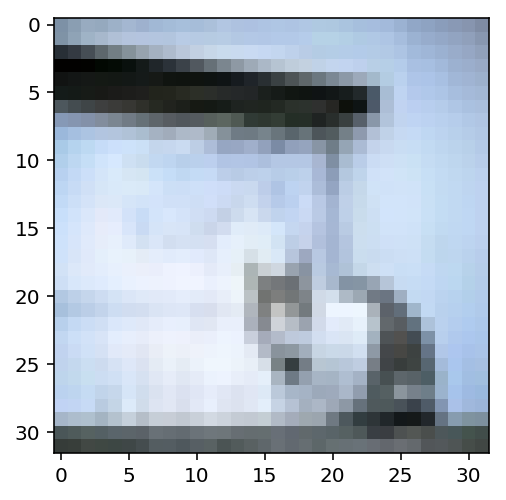

In [45]:
predictions(6)

In [36]:
[print(n.name) for n in defaultGraph.as_graph_def().node]

[]

In [37]:
def serving_input_receiver_fn():

    feature_tensor = tf.placeholder(tf.float32, [None, 32,32,3])
    return tf.estimator.export.TensorServingInputReceiver(feature_tensor, {'input': feature_tensor})

In [38]:
#cifar10_classifier.export_savedmodel(savedir, serving_input_receiver_fn,
#    strip_default_attrs=True)


In [39]:
input_receiver_fn_map={
    tf.estimator.ModeKeys.PREDICT: serving_input_receiver_fn,
    }

cifar10_classifier.experimental_export_all_saved_models(
    savedir, 
    input_receiver_fn_map)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict_output', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from models/Tensor_CIFAR_Sparse_model/run-20190426161558/model.ckpt-14063
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/Tensor_CIFAR_Sparse_model/run-20190426161558/temp-b'1556297486'/saved_model.pb


b'models/Tensor_CIFAR_Sparse_model/run-20190426161558/1556297486'